In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.circuit.barrier import Barrier
from qiskit import schedule as build_schedule
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')
#backend = provider.get_backend('ibmq_guadalupe')
#backend = provider.get_backend('ibmq_bogota')
#backend = provider.get_backend('ibmq_toronto')

In [3]:
status = backend.status()

In [3]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
calibrations = backend_defaults.instruction_schedule_map

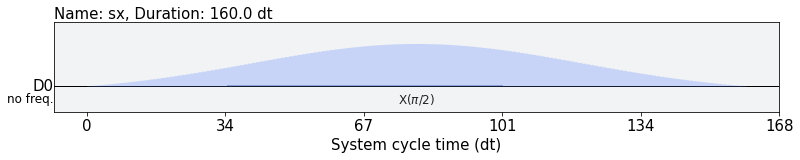

In [4]:
x_schedule = calibrations.get('x', [0])
x_pulse = x_schedule.instructions[0][1].pulse
sx_schedule = calibrations.get('sx', [0])
sx_pulse = sx_schedule.instructions[0][1].pulse
cx_schedule = calibrations.get('cx', (0, 1))
sx_schedule.draw()

In [5]:
print(x_pulse)
print(sx_pulse)

Drag(duration=160, amp=(0.18902066555725738+0j), sigma=40, beta=0.36798292191086207, name='Xp_d0')
Drag(duration=160, amp=(0.09231687533466496+0.0022221600219800215j), sigma=40, beta=0.41371337026188004, name='X90p_d0')


# Experiment 1: Hadamard

In [ ]:
circuit = QuantumCircuit(1)
circuit.h(0)
circuit.measure_all()
circuit = transpile(circuit, backend=backend)
circuit.draw('mpl', idle_wires=False)

In [ ]:
job = backend.run(circuit, shots=8192)
job_monitor(job)
result = job.result()
print(result.get_counts())

In [ ]:
sxp = sx_schedule.instructions[0][1].pulse
schedules = []
scales = np.linspace(0., 2., 21)
for scale in scales:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
        pulse.play(pulse.Drag(duration=sxp.duration, amp=(sxp.amp * scale), sigma=sxp.sigma, beta=sxp.beta), pulse.drive_channel(0))
        pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)
    
sched.draw()

In [ ]:
job = backend.run(schedules, meas_level=2, shots=8192)
job_monitor(job)
result = job.result()

In [ ]:
yvalues = plot_counts(result, ['0'], x=scales)

In [ ]:
popt, _ = scipy.optimize.curve_fit(lambda x, omega, p, a, o: o + a * np.cos(x * omega + p), scales, yvalues, p0=[np.pi / 2., 0., 1., 0.5])
print(popt)

In [ ]:
omega, p, a, o = popt
plt.scatter(scales, yvalues)
plt.plot(scales, o + a * np.cos(scales * omega + p))
plt.plot([0., 2.], [0.5, 0.5], 'b-')
plt.plot([1., 1.], [0., 1.], 'b-')
plt.plot([1.], [4531. / 8192.], 'ro')

In [ ]:
pprint.pprint(build_schedule(circuit, backend=backend).instructions)

In [ ]:
scales

In [ ]:
sxp = sx_schedule.instructions[0][1].pulse
schedules_sx = []
scales = np.linspace(0., 2., 21)
for scale in scales:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        pulse.play(pulse.Drag(duration=sxp.duration, amp=(sxp.amp * scale), sigma=sxp.sigma, beta=sxp.beta), pulse.drive_channel(0))
        pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules_sx.append(sched)

In [ ]:
job = backend.run(schedules_sx, meas_level=2, shots=8192)
job_monitor(job)
result = job.result()

In [ ]:
yvalues_sx = plot_counts(result, ['0'], x=scales)
popt_sx, _ = scipy.optimize.curve_fit(lambda x, omega, p, a, o: o + a * np.cos(x * omega + p), scales, yvalues_sx, p0=[np.pi / 2., 0., 1., 0.5])
print(popt_sx)

In [ ]:
omega_sx, p_sx, a_sx, o_sx = popt_sx
plt.scatter(scales, yvalues)
plt.plot(scales, o + a * np.cos(scales * omega + p))
plt.scatter(scales, yvalues_sx)
plt.plot(scales, o_sx + a_sx * np.cos(scales * omega_sx + p_sx))
plt.plot([0., 2.], [0.5, 0.5], 'b-')
plt.plot([1., 1.], [0., 1.], 'b-')
plt.plot([1.], [4531. / 8192.], 'ro')

# Experiment 2: CNOT

In [ ]:
with pulse.build(backend=backend, default_alignment='sequential') as x_cx_sched:
    pulse.play(x_pulse, pulse.drive_channel(0))
    pulse.call(cx_schedule)
    pulse.measure(qubits=[0, 1], registers=[pulse.MemorySlot(0), pulse.MemorySlot(1)])
    
x_cx_sched.draw()

In [ ]:
with pulse.build(backend=backend, default_alignment='sequential') as h_cx_sched:
    pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
    pulse.play(sxp, pulse.drive_channel(0))
    pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
    pulse.call(cx_schedule)
    pulse.measure(qubits=[0, 1], registers=[pulse.MemorySlot(0), pulse.MemorySlot(1)])
    
h_cx_sched.draw()

In [ ]:
job = backend.run([x_cx_sched, h_cx_sched], shots=8192)
job_monitor(job)
job.result().get_counts()

# Experiment 3: X with a phase shift

In [6]:
x_schedules = []

with pulse.build(backend=backend, default_alignment='sequential') as sched:
    pulse.play(x_pulse, pulse.drive_channel(0))
    pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
    
x_schedules.append(sched)

with pulse.build(backend=backend, default_alignment='sequential') as sched:
    pulse.shift_phase(-np.pi / 2., pulse.drive_channel(0))
    pulse.play(x_pulse, pulse.drive_channel(0))
    pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
    
x_schedules.append(sched)

with pulse.build(backend=backend, default_alignment='sequential') as sched:
    pulse.shift_phase(-np.pi, pulse.drive_channel(0))
    pulse.play(x_pulse, pulse.drive_channel(0))
    pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
    
x_schedules.append(sched)

job = backend.run(x_schedules, meas_level=2, shots=8192)
job_monitor(job)
job.result().get_counts()

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


[{'0': 232, '1': 7960}, {'0': 216, '1': 7976}, {'0': 218, '1': 7974}]

# Experiment 4: Phase shift sweep of $\sqrt{X}$

In [12]:
phases = np.linspace(-np.pi, np.pi, 21)

sweep_schedules = []

for phase in phases:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        pulse.shift_phase(phase, pulse.drive_channel(0))
        pulse.play(sx_pulse, pulse.drive_channel(0))
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    sweep_schedules.append(sched)
    
job = backend.run(sweep_schedules, meas_level=2, shots=4096)
job_monitor(job)
result = job.result()

Job Status: job has successfully run


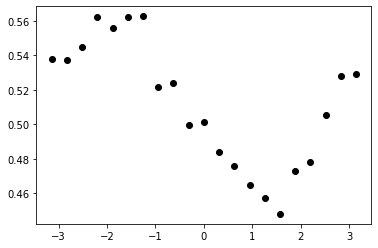

In [13]:
yvalues = plot_counts(result, ['0'], x=phases)

In [ ]:
plt.errorbar(phases, yvalues, yerr=np.sqrt(yvalues * (1. - yvalues)))

In [1]:
backend

NameError: name 'backend' is not defined